## 주요 변동사항

### 가. 피처

* CONV 2D 기반 피처 생성하였습니다. 가격 등급(7단계) - 중분류('gds_grp_nm')  기존변수 요일 - 중분류('gds_grp_nm') 교체
* 가격의 7단계는 성비(남 - 37%)와 전체 구매비중(남 - 27%)을 모두 고려하여 환불, 0 ~ 3000원 구간 ... 300만원 초과로 구성하였습니다.


### 나. 파이프라인

* 중대 결함 수정 : X_train의 크기가 0.2% 씩 감소하는 현상 발생 -> for문 내부적으로 전역변수 X_train을 호출하여 train_test_split 하여 X_train 저장
* (random seed에 의한 앙상블)모델의 일반화 성능을 확인하기 위해 N 30회 증강 및 기존 0.7 -> 0.76으로 기준치 상향 조정하였습니다. 

## This model has the following characteristics:
* No feature engineering
* Applying Conv2D to raw transactions

In [1]:
%run import_modules.py  
%matplotlib inline

# For DNN modeling
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.initializers import *
from tensorflow.keras.regularizers import *
from tensorflow.keras.utils import * # model_to_dot, to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.preprocessing.text import *

# Tensorflow warning off
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

SEED = 10334            # seed 숫자를 지정
random.seed(SEED)     # Python 고정
np.random.seed(SEED)  # numpy 고정
tf.random.set_seed(SEED) # Tensorflow 고정

### Read Data

In [2]:
df_train = pd.read_csv('X_train.csv', encoding='cp949')
df_test = pd.read_csv('X_test.csv', encoding='cp949')
y_train = pd.read_csv('y_train.csv').gender
IDtest = df_test.cust_id.unique()

# df_test.head()

### Transform Data

In [3]:
def price_range(amount):
   
    if amount < 0 :
       
        return 0
   
    elif amount >= 0 and amount < 3000:
       
        return 1
   
    elif amount >= 3000 and amount < 20000:
       
        return 2
   
    elif amount >= 20000 and amount < 70000:
       
        return 3
   
    elif amount >= 70000 and amount < 250000:
       
        return 4
   
    elif amount >= 250000 and amount < 3000000:
       
        return 5

    else :
       
        return 6

df_train['price_range'] = df_train['amount'].apply(price_range)
df_test['price_range'] = df_test['amount'].apply(price_range)

In [4]:
%%time

level = 'gds_grp_nm'
items = list(set(df_train[level]) | set(df_test[level]))
ncol = len(items)

def make_image(df):
    x = pd.DataFrame({'cust_id': df.cust_id.unique()})
    y = pd.DataFrame({level: items})
    z = pd.DataFrame({'price_range': np.arange(7)})
    df_pad = (
        x.assign(key=1)
        .merge(y.assign(key=1), on="key")
        .merge(z.assign(key=1), on="key")
        .drop("key", axis=1)
        .assign(amount=0)
    )
    # df['week_day'] = pd.to_datetime(df.tran_date).dt.weekday
    df_all = pd.concat([df, df_pad], sort=False, axis=0)
    x = pd.pivot_table(df_all.query('amount >= 0'), 
                       index=['cust_id','price_range'], columns=level, 
                       values='amount', aggfunc=np.size, fill_value=0)
    x = np.array(x).reshape(-1,7*ncol) - 1
    return x.reshape(-1,7,ncol,1)
#    x = np.array(x).reshape(-1,7*ncol) - 1
#    return (x / x.max(1).reshape(-1,1)).reshape(-1,7,ncol,1)

X_train = make_image(df_train)
X_test = make_image(df_test)

X_train.shape, X_test.shape

Wall time: 1min 43s


((3500, 7, 331, 1), (2482, 7, 331, 1))

In [5]:
# fig, ax = plt.subplots(figsize=(15,8))
# sns.heatmap(train.reshape(-1,7,ncol)[715], ax=ax)
# plt.show()

### Build Models

In [6]:
'''
from tensorflow.keras.callbacks import ReduceLROnPlateau

callback_list = [
    
    EarlyStopping(
        
        patience = 10
    ),
    
    ReduceLROnPlateau(
        
        factor = 0.1,
        monitor = 'val_acc',
        patience = 7,
    )
]
'''

  0%|                                                                                           | 0/30 [00:00<?, ?it/s]

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 7, 331, 1)         2         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 7, 331, 1)         2         
_________________________________________________________________
flatten (Flatten)            (None, 2317)              0         
_________________________________________________________________
dense (Dense)                (None, 16)                37088     
_________________________________________________________________
dropout (Dropout)            (None, 16)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 37,109
Trainable params: 37,109
Non-trainable params: 0
____________________________________________________

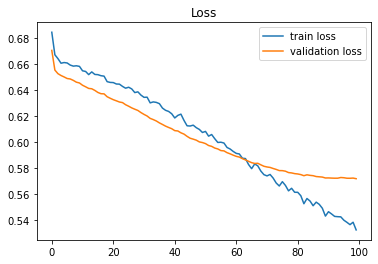

  3%|██▊                                                                                | 1/30 [00:29<14:19, 29.62s/it]

AUC 0.7774012233427012
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 7, 331, 1)         2         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 7, 331, 1)         2         
_________________________________________________________________
flatten_1 (Flatten)          (None, 2317)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 16)                37088     
_________________________________________________________________
dropout_1 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 17        
Total params: 37,109
Trainable params: 37,109
Non-trainable params: 0
___________________________

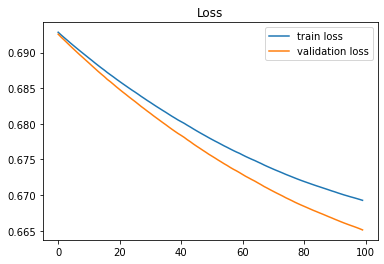

AUC 0.5


  7%|█████▌                                                                             | 2/30 [01:06<14:47, 31.68s/it]

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 7, 331, 1)         2         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 7, 331, 1)         2         
_________________________________________________________________
flatten_2 (Flatten)          (None, 2317)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 16)                37088     
_________________________________________________________________
dropout_2 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 17        
Total params: 37,109
Trainable params: 37,109
Non-trainable params: 0
__________________________________________________

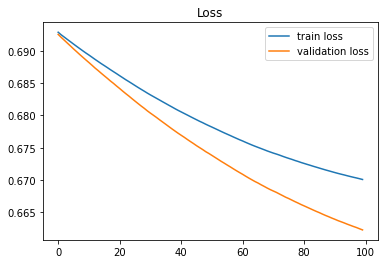

AUC 0.5


 10%|████████▎                                                                          | 3/30 [01:50<15:56, 35.42s/it]

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 7, 331, 1)         2         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 7, 331, 1)         2         
_________________________________________________________________
flatten_3 (Flatten)          (None, 2317)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 16)                37088     
_________________________________________________________________
dropout_3 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 17        
Total params: 37,109
Trainable params: 37,109
Non-trainable params: 0
__________________________________________________

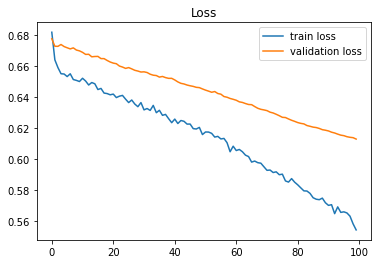

AUC 0.7467175957748562


 13%|███████████                                                                        | 4/30 [02:32<16:14, 37.48s/it]

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 7, 331, 1)         2         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 7, 331, 1)         2         
_________________________________________________________________
flatten_4 (Flatten)          (None, 2317)              0         
_________________________________________________________________
dense_8 (Dense)              (None, 16)                37088     
_________________________________________________________________
dropout_4 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 17        
Total params: 37,109
Trainable params: 37,109
Non-trainable params: 0
__________________________________________________

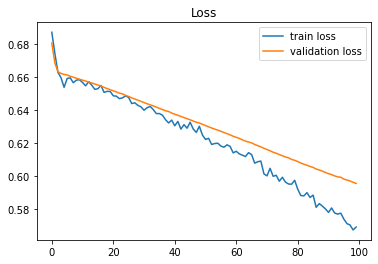

AUC 0.751050630378227


 17%|█████████████▊                                                                     | 5/30 [03:10<15:43, 37.74s/it]

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 7, 331, 1)         2         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 7, 331, 1)         2         
_________________________________________________________________
flatten_5 (Flatten)          (None, 2317)              0         
_________________________________________________________________
dense_10 (Dense)             (None, 16)                37088     
_________________________________________________________________
dropout_5 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 17        
Total params: 37,109
Trainable params: 37,109
Non-trainable params: 0
__________________________________________________

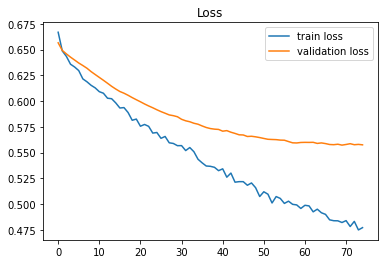

AUC 0.724526019959802


 20%|████████████████▌                                                                  | 6/30 [03:40<14:05, 35.21s/it]

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 7, 331, 1)         2         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 7, 331, 1)         2         
_________________________________________________________________
flatten_6 (Flatten)          (None, 2317)              0         
_________________________________________________________________
dense_12 (Dense)             (None, 16)                37088     
_________________________________________________________________
dropout_6 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 17        
Total params: 37,109
Trainable params: 37,109
Non-trainable params: 0
__________________________________________________

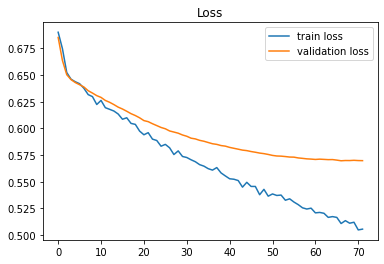

AUC 0.783348269831464


 23%|███████████████████▎                                                               | 7/30 [04:11<13:05, 34.16s/it]

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_14 (Conv2D)           (None, 7, 331, 1)         2         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 7, 331, 1)         2         
_________________________________________________________________
flatten_7 (Flatten)          (None, 2317)              0         
_________________________________________________________________
dense_14 (Dense)             (None, 16)                37088     
_________________________________________________________________
dropout_7 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 17        
Total params: 37,109
Trainable params: 37,109
Non-trainable params: 0
__________________________________________________

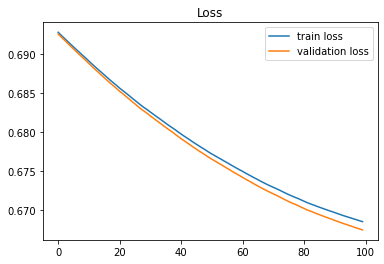

AUC 0.5


 27%|██████████████████████▏                                                            | 8/30 [04:54<13:28, 36.77s/it]

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_16 (Conv2D)           (None, 7, 331, 1)         2         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 7, 331, 1)         2         
_________________________________________________________________
flatten_8 (Flatten)          (None, 2317)              0         
_________________________________________________________________
dense_16 (Dense)             (None, 16)                37088     
_________________________________________________________________
dropout_8 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_17 (Dense)             (None, 1)                 17        
Total params: 37,109
Trainable params: 37,109
Non-trainable params: 0
__________________________________________________

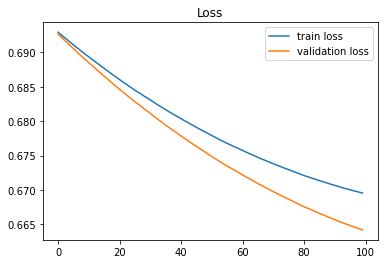

AUC 0.5


 30%|████████████████████████▉                                                          | 9/30 [05:36<13:23, 38.24s/it]

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_18 (Conv2D)           (None, 7, 331, 1)         2         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 7, 331, 1)         2         
_________________________________________________________________
flatten_9 (Flatten)          (None, 2317)              0         
_________________________________________________________________
dense_18 (Dense)             (None, 16)                37088     
_________________________________________________________________
dropout_9 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_19 (Dense)             (None, 1)                 17        
Total params: 37,109
Trainable params: 37,109
Non-trainable params: 0
__________________________________________________

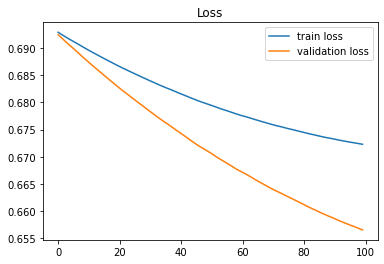

AUC 0.5


 33%|███████████████████████████▎                                                      | 10/30 [06:17<13:00, 39.05s/it]

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_20 (Conv2D)           (None, 7, 331, 1)         2         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 7, 331, 1)         2         
_________________________________________________________________
flatten_10 (Flatten)         (None, 2317)              0         
_________________________________________________________________
dense_20 (Dense)             (None, 16)                37088     
_________________________________________________________________
dropout_10 (Dropout)         (None, 16)                0         
_________________________________________________________________
dense_21 (Dense)             (None, 1)                 17        
Total params: 37,109
Trainable params: 37,109
Non-trainable params: 0
_________________________________________________

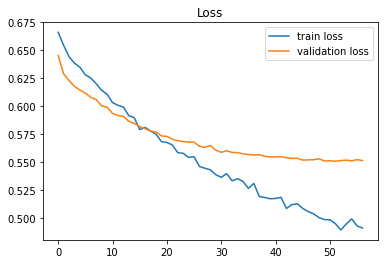

AUC 0.7494757724199739


 37%|██████████████████████████████                                                    | 11/30 [06:40<10:53, 34.38s/it]

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_22 (Conv2D)           (None, 7, 331, 1)         2         
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 7, 331, 1)         2         
_________________________________________________________________
flatten_11 (Flatten)         (None, 2317)              0         
_________________________________________________________________
dense_22 (Dense)             (None, 16)                37088     
_________________________________________________________________
dropout_11 (Dropout)         (None, 16)                0         
_________________________________________________________________
dense_23 (Dense)             (None, 1)                 17        
Total params: 37,109
Trainable params: 37,109
Non-trainable params: 0
_________________________________________________

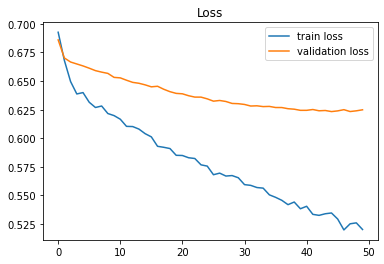

AUC 0.7571586430118941


 40%|████████████████████████████████▊                                                 | 12/30 [06:58<08:50, 29.47s/it]

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_24 (Conv2D)           (None, 7, 331, 1)         2         
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 7, 331, 1)         2         
_________________________________________________________________
flatten_12 (Flatten)         (None, 2317)              0         
_________________________________________________________________
dense_24 (Dense)             (None, 16)                37088     
_________________________________________________________________
dropout_12 (Dropout)         (None, 16)                0         
_________________________________________________________________
dense_25 (Dense)             (None, 1)                 17        
Total params: 37,109
Trainable params: 37,109
Non-trainable params: 0
_________________________________________________

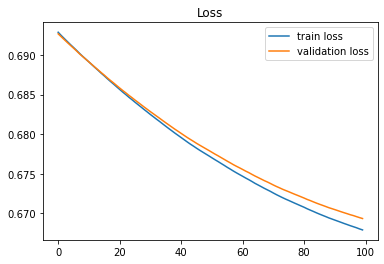

AUC 0.5


 43%|███████████████████████████████████▌                                              | 13/30 [07:34<08:52, 31.32s/it]

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_26 (Conv2D)           (None, 7, 331, 1)         2         
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 7, 331, 1)         2         
_________________________________________________________________
flatten_13 (Flatten)         (None, 2317)              0         
_________________________________________________________________
dense_26 (Dense)             (None, 16)                37088     
_________________________________________________________________
dropout_13 (Dropout)         (None, 16)                0         
_________________________________________________________________
dense_27 (Dense)             (None, 1)                 17        
Total params: 37,109
Trainable params: 37,109
Non-trainable params: 0
_________________________________________________

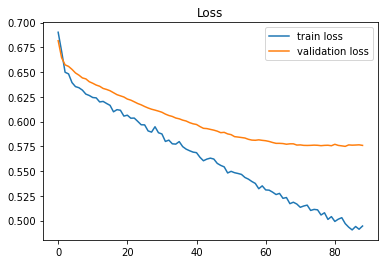

AUC 0.7478704614072792


 47%|██████████████████████████████████████▎                                           | 14/30 [08:06<08:22, 31.41s/it]

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_28 (Conv2D)           (None, 7, 331, 1)         2         
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 7, 331, 1)         2         
_________________________________________________________________
flatten_14 (Flatten)         (None, 2317)              0         
_________________________________________________________________
dense_28 (Dense)             (None, 16)                37088     
_________________________________________________________________
dropout_14 (Dropout)         (None, 16)                0         
_________________________________________________________________
dense_29 (Dense)             (None, 1)                 17        
Total params: 37,109
Trainable params: 37,109
Non-trainable params: 0
_________________________________________________

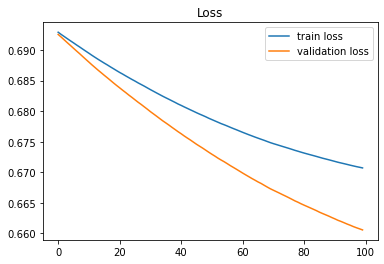

AUC 0.5


 50%|█████████████████████████████████████████                                         | 15/30 [08:42<08:11, 32.75s/it]

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_30 (Conv2D)           (None, 7, 331, 1)         2         
_________________________________________________________________
conv2d_31 (Conv2D)           (None, 7, 331, 1)         2         
_________________________________________________________________
flatten_15 (Flatten)         (None, 2317)              0         
_________________________________________________________________
dense_30 (Dense)             (None, 16)                37088     
_________________________________________________________________
dropout_15 (Dropout)         (None, 16)                0         
_________________________________________________________________
dense_31 (Dense)             (None, 1)                 17        
Total params: 37,109
Trainable params: 37,109
Non-trainable params: 0
_________________________________________________

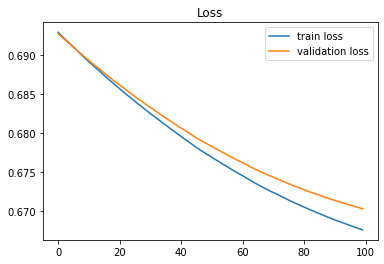

AUC 0.5


 53%|███████████████████████████████████████████▋                                      | 16/30 [09:16<07:46, 33.34s/it]

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_32 (Conv2D)           (None, 7, 331, 1)         2         
_________________________________________________________________
conv2d_33 (Conv2D)           (None, 7, 331, 1)         2         
_________________________________________________________________
flatten_16 (Flatten)         (None, 2317)              0         
_________________________________________________________________
dense_32 (Dense)             (None, 16)                37088     
_________________________________________________________________
dropout_16 (Dropout)         (None, 16)                0         
_________________________________________________________________
dense_33 (Dense)             (None, 1)                 17        
Total params: 37,109
Trainable params: 37,109
Non-trainable params: 0
_________________________________________________

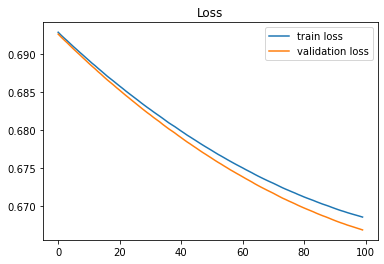

AUC 0.5


 57%|██████████████████████████████████████████████▍                                   | 17/30 [09:57<07:42, 35.59s/it]

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_34 (Conv2D)           (None, 7, 331, 1)         2         
_________________________________________________________________
conv2d_35 (Conv2D)           (None, 7, 331, 1)         2         
_________________________________________________________________
flatten_17 (Flatten)         (None, 2317)              0         
_________________________________________________________________
dense_34 (Dense)             (None, 16)                37088     
_________________________________________________________________
dropout_17 (Dropout)         (None, 16)                0         
_________________________________________________________________
dense_35 (Dense)             (None, 1)                 17        
Total params: 37,109
Trainable params: 37,109
Non-trainable params: 0
_________________________________________________

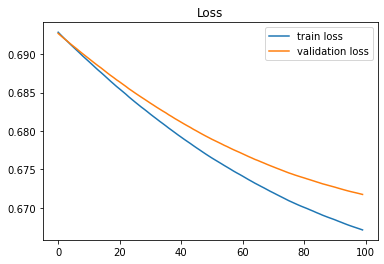

AUC 0.5015313535947655


 60%|█████████████████████████████████████████████████▏                                | 18/30 [10:33<07:08, 35.72s/it]

Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_36 (Conv2D)           (None, 7, 331, 1)         2         
_________________________________________________________________
conv2d_37 (Conv2D)           (None, 7, 331, 1)         2         
_________________________________________________________________
flatten_18 (Flatten)         (None, 2317)              0         
_________________________________________________________________
dense_36 (Dense)             (None, 16)                37088     
_________________________________________________________________
dropout_18 (Dropout)         (None, 16)                0         
_________________________________________________________________
dense_37 (Dense)             (None, 1)                 17        
Total params: 37,109
Trainable params: 37,109
Non-trainable params: 0
_________________________________________________

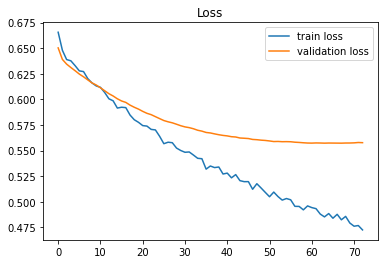

AUC 0.7465914331207419


 63%|███████████████████████████████████████████████████▉                              | 19/30 [10:59<06:02, 32.92s/it]

Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_38 (Conv2D)           (None, 7, 331, 1)         2         
_________________________________________________________________
conv2d_39 (Conv2D)           (None, 7, 331, 1)         2         
_________________________________________________________________
flatten_19 (Flatten)         (None, 2317)              0         
_________________________________________________________________
dense_38 (Dense)             (None, 16)                37088     
_________________________________________________________________
dropout_19 (Dropout)         (None, 16)                0         
_________________________________________________________________
dense_39 (Dense)             (None, 1)                 17        
Total params: 37,109
Trainable params: 37,109
Non-trainable params: 0
_________________________________________________

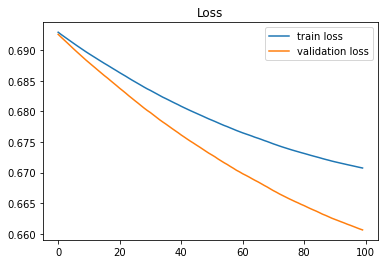

AUC 0.5


 67%|██████████████████████████████████████████████████████▋                           | 20/30 [11:35<05:36, 33.66s/it]

Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_40 (Conv2D)           (None, 7, 331, 1)         2         
_________________________________________________________________
conv2d_41 (Conv2D)           (None, 7, 331, 1)         2         
_________________________________________________________________
flatten_20 (Flatten)         (None, 2317)              0         
_________________________________________________________________
dense_40 (Dense)             (None, 16)                37088     
_________________________________________________________________
dropout_20 (Dropout)         (None, 16)                0         
_________________________________________________________________
dense_41 (Dense)             (None, 1)                 17        
Total params: 37,109
Trainable params: 37,109
Non-trainable params: 0
_________________________________________________

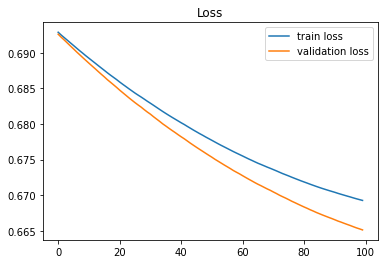

AUC 0.5


 70%|█████████████████████████████████████████████████████████▍                        | 21/30 [12:12<05:12, 34.69s/it]

Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_42 (Conv2D)           (None, 7, 331, 1)         2         
_________________________________________________________________
conv2d_43 (Conv2D)           (None, 7, 331, 1)         2         
_________________________________________________________________
flatten_21 (Flatten)         (None, 2317)              0         
_________________________________________________________________
dense_42 (Dense)             (None, 16)                37088     
_________________________________________________________________
dropout_21 (Dropout)         (None, 16)                0         
_________________________________________________________________
dense_43 (Dense)             (None, 1)                 17        
Total params: 37,109
Trainable params: 37,109
Non-trainable params: 0
_________________________________________________

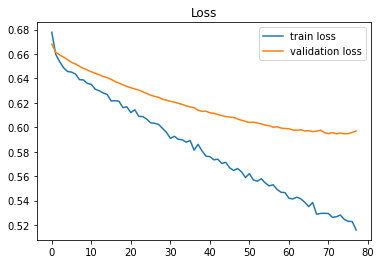

AUC 0.7633884678633267


 73%|████████████████████████████████████████████████████████████▏                     | 22/30 [12:44<04:31, 33.96s/it]

Model: "sequential_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_44 (Conv2D)           (None, 7, 331, 1)         2         
_________________________________________________________________
conv2d_45 (Conv2D)           (None, 7, 331, 1)         2         
_________________________________________________________________
flatten_22 (Flatten)         (None, 2317)              0         
_________________________________________________________________
dense_44 (Dense)             (None, 16)                37088     
_________________________________________________________________
dropout_22 (Dropout)         (None, 16)                0         
_________________________________________________________________
dense_45 (Dense)             (None, 1)                 17        
Total params: 37,109
Trainable params: 37,109
Non-trainable params: 0
_________________________________________________

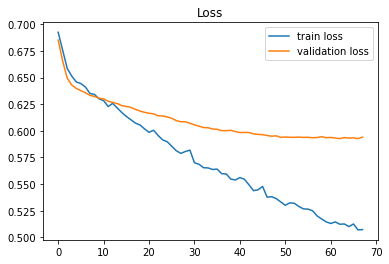

AUC 0.7702882599124692


 77%|██████████████████████████████████████████████████████████████▊                   | 23/30 [13:14<03:49, 32.75s/it]

Model: "sequential_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_46 (Conv2D)           (None, 7, 331, 1)         2         
_________________________________________________________________
conv2d_47 (Conv2D)           (None, 7, 331, 1)         2         
_________________________________________________________________
flatten_23 (Flatten)         (None, 2317)              0         
_________________________________________________________________
dense_46 (Dense)             (None, 16)                37088     
_________________________________________________________________
dropout_23 (Dropout)         (None, 16)                0         
_________________________________________________________________
dense_47 (Dense)             (None, 1)                 17        
Total params: 37,109
Trainable params: 37,109
Non-trainable params: 0
_________________________________________________

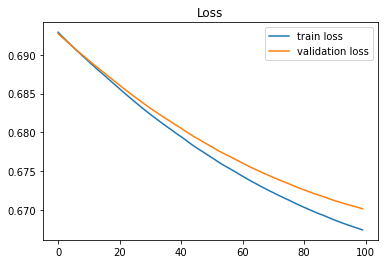

AUC 0.5


 80%|█████████████████████████████████████████████████████████████████▌                | 24/30 [13:56<03:33, 35.61s/it]

Model: "sequential_24"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_48 (Conv2D)           (None, 7, 331, 1)         2         
_________________________________________________________________
conv2d_49 (Conv2D)           (None, 7, 331, 1)         2         
_________________________________________________________________
flatten_24 (Flatten)         (None, 2317)              0         
_________________________________________________________________
dense_48 (Dense)             (None, 16)                37088     
_________________________________________________________________
dropout_24 (Dropout)         (None, 16)                0         
_________________________________________________________________
dense_49 (Dense)             (None, 1)                 17        
Total params: 37,109
Trainable params: 37,109
Non-trainable params: 0
_________________________________________________

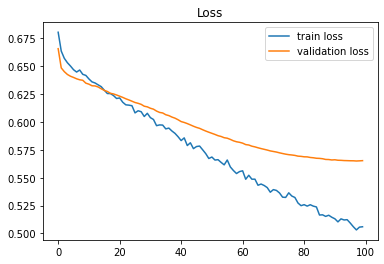

AUC 0.7341578860359694


 83%|████████████████████████████████████████████████████████████████████▎             | 25/30 [14:38<03:06, 37.27s/it]

Model: "sequential_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_50 (Conv2D)           (None, 7, 331, 1)         2         
_________________________________________________________________
conv2d_51 (Conv2D)           (None, 7, 331, 1)         2         
_________________________________________________________________
flatten_25 (Flatten)         (None, 2317)              0         
_________________________________________________________________
dense_50 (Dense)             (None, 16)                37088     
_________________________________________________________________
dropout_25 (Dropout)         (None, 16)                0         
_________________________________________________________________
dense_51 (Dense)             (None, 1)                 17        
Total params: 37,109
Trainable params: 37,109
Non-trainable params: 0
_________________________________________________

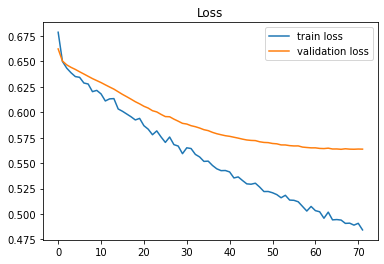

AUC 0.7553053571273199


 87%|███████████████████████████████████████████████████████████████████████           | 26/30 [15:06<02:18, 34.70s/it]

Model: "sequential_26"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_52 (Conv2D)           (None, 7, 331, 1)         2         
_________________________________________________________________
conv2d_53 (Conv2D)           (None, 7, 331, 1)         2         
_________________________________________________________________
flatten_26 (Flatten)         (None, 2317)              0         
_________________________________________________________________
dense_52 (Dense)             (None, 16)                37088     
_________________________________________________________________
dropout_26 (Dropout)         (None, 16)                0         
_________________________________________________________________
dense_53 (Dense)             (None, 1)                 17        
Total params: 37,109
Trainable params: 37,109
Non-trainable params: 0
_________________________________________________

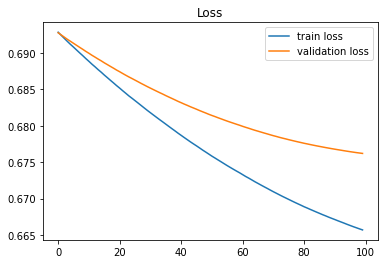

AUC 0.5


 90%|█████████████████████████████████████████████████████████████████████████▊        | 27/30 [15:46<01:48, 36.19s/it]

Model: "sequential_27"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_54 (Conv2D)           (None, 7, 331, 1)         2         
_________________________________________________________________
conv2d_55 (Conv2D)           (None, 7, 331, 1)         2         
_________________________________________________________________
flatten_27 (Flatten)         (None, 2317)              0         
_________________________________________________________________
dense_54 (Dense)             (None, 16)                37088     
_________________________________________________________________
dropout_27 (Dropout)         (None, 16)                0         
_________________________________________________________________
dense_55 (Dense)             (None, 1)                 17        
Total params: 37,109
Trainable params: 37,109
Non-trainable params: 0
_________________________________________________

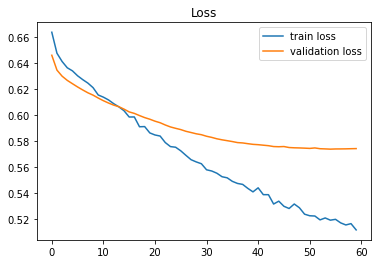

AUC 0.7456082345059208


 93%|████████████████████████████████████████████████████████████████████████████▌     | 28/30 [16:11<01:05, 32.90s/it]

Model: "sequential_28"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_56 (Conv2D)           (None, 7, 331, 1)         2         
_________________________________________________________________
conv2d_57 (Conv2D)           (None, 7, 331, 1)         2         
_________________________________________________________________
flatten_28 (Flatten)         (None, 2317)              0         
_________________________________________________________________
dense_56 (Dense)             (None, 16)                37088     
_________________________________________________________________
dropout_28 (Dropout)         (None, 16)                0         
_________________________________________________________________
dense_57 (Dense)             (None, 1)                 17        
Total params: 37,109
Trainable params: 37,109
Non-trainable params: 0
_________________________________________________

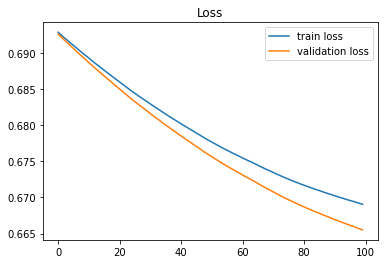

AUC 0.5


 97%|███████████████████████████████████████████████████████████████████████████████▎  | 29/30 [16:54<00:35, 35.76s/it]

Model: "sequential_29"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_58 (Conv2D)           (None, 7, 331, 1)         2         
_________________________________________________________________
conv2d_59 (Conv2D)           (None, 7, 331, 1)         2         
_________________________________________________________________
flatten_29 (Flatten)         (None, 2317)              0         
_________________________________________________________________
dense_58 (Dense)             (None, 16)                37088     
_________________________________________________________________
dropout_29 (Dropout)         (None, 16)                0         
_________________________________________________________________
dense_59 (Dense)             (None, 1)                 17        
Total params: 37,109
Trainable params: 37,109
Non-trainable params: 0
_________________________________________________

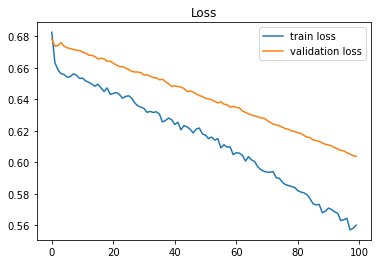

AUC 0.7377556968963987


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [17:34<00:00, 35.15s/it]


Validation Summary:
6     0.783348
0     0.777401
22    0.770288
21    0.763388
11    0.757159
25    0.755305
4     0.751051
10    0.749476
13    0.747870
3     0.746718
18    0.746591
27    0.745608
29    0.737756
24    0.734158
5     0.724526
17    0.501531
16    0.500000
7     0.500000
1     0.500000
2     0.500000
26    0.500000
23    0.500000
8     0.500000
15    0.500000
9     0.500000
20    0.500000
19    0.500000
12    0.500000
28    0.500000
14    0.500000
dtype: float64
mean=0.62641, std=0.129
Wall time: 17min 34s


In [7]:
%%time

# Set hyper-parameters for power mean ensemble 
N = 30
p = 3.5
preds = []
aucs = []

for i in tqdm(range(N)): 
    
    train_x, valid_x, train_y, valid_y = train_test_split(X_train, y_train, test_size = 0.2, stratify = y_train, random_state = i)

    model = Sequential()
    model.add(Conv2D(1, kernel_size=(1, 1),strides=(1,1), activation='tanh', input_shape=(7,ncol,1)))
    # model.add(MaxPooling2D(pool_size=(2, 1)))
    model.add(Conv2D(1, kernel_size=(1, 1),strides=(1,1), activation='relu'))
    model.add(Flatten())
    model.add(Dense(16, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(1, activation='sigmoid'))
    model.summary()

    # model.compile(optimizer='adadelta', loss='binary_crossentropy', metrics=['acc'])
    model.compile(optimizer=RMSprop(lr=1e-4), loss='binary_crossentropy', metrics=['acc'])

    history = model.fit(train_x, train_y, epochs=100, batch_size=64, validation_split=0.2, callbacks=[EarlyStopping(patience=5)], verbose = 0)
    
    print('CNN 2D learning curve', i+1)
    plt.plot(history.history["loss"], label="train loss")
    plt.plot(history.history["val_loss"], label="validation loss")
    plt.legend()
    plt.title("Loss")
    plt.show()
    
    # Make Prediction
    auc = roc_auc_score(valid_y, model.predict(valid_x).flatten())
    aucs.append(auc)
    print('AUC', auc)
    preds.append(model.predict(X_test).flatten())   

### Validate the Models
print('\nValidation Summary:')
aucs = pd.Series(aucs)
print(aucs.sort_values(ascending=False))
print('mean={:.5f}, std={:.3f}'.format(aucs.mean(), aucs.std())) 

### Make Submissions

In [8]:
# Power mean ensemble
THRESHOLD = 0.76  # Use only models whose AUC exceeds this value

pred = 0
n = 0
for i in range(N):
    if aucs.iloc[i] > THRESHOLD:
        pred = pred + preds[i]**p 
        n += 1
pred = pred / n    
pred = pred**(1/p)

# Make a submission file

t = pd.Timestamp.now()
fname = f"dae_p{p}n{n}_submit_{t.month:02}{t.day:02}{t.hour:02}{t.minute:02}.csv"
submissions = pd.concat([pd.Series(IDtest, name="cust_id"), pd.Series(pred, name="gender")] ,axis=1)
submissions.to_csv(fname, index=False)
print(f"'{fname}' is ready to submit.")

'dae_p3.5n4_submit_06140251.csv' is ready to submit.


## End